# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  360448/11490434 [..............................] - ETA: 1s

 5742592/11490434 [=============>................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:15 - loss: 0.6971

  28/1875 [..............................] - ETA: 3s - loss: 0.5554   

  49/1875 [..............................] - ETA: 3s - loss: 0.4883

  76/1875 [>.............................] - ETA: 3s - loss: 0.4396

  98/1875 [>.............................] - ETA: 3s - loss: 0.4140

 125/1875 [=>............................] - ETA: 3s - loss: 0.3914

 153/1875 [=>............................] - ETA: 3s - loss: 0.3738

 182/1875 [=>............................] - ETA: 3s - loss: 0.3592

 213/1875 [==>...........................] - ETA: 3s - loss: 0.3464

 244/1875 [==>...........................] - ETA: 3s - loss: 0.3356

 272/1875 [===>..........................] - ETA: 3s - loss: 0.3272

 298/1875 [===>..........................] - ETA: 3s - loss: 0.3202

 327/1875 [====>.........................] - ETA: 2s - loss: 0.3133

 358/1875 [====>.........................] - ETA: 2s - loss: 0.3066

 386/1875 [=====>........................] - ETA: 2s - loss: 0.3011

 411/1875 [=====>........................] - ETA: 2s - loss: 0.2966

 441/1875 [======>.......................] - ETA: 2s - loss: 0.2916

 464/1875 [======>.......................] - ETA: 2s - loss: 0.2880

 485/1875 [======>.......................] - ETA: 2s - loss: 0.2849

 509/1875 [=======>......................] - ETA: 2s - loss: 0.2816

 532/1875 [=======>......................] - ETA: 2s - loss: 0.2786

 557/1875 [=======>......................] - ETA: 2s - loss: 0.2754

 582/1875 [========>.....................] - ETA: 2s - loss: 0.2725

 604/1875 [========>.....................] - ETA: 2s - loss: 0.2700

 626/1875 [=========>....................] - ETA: 2s - loss: 0.2676

 648/1875 [=========>....................] - ETA: 2s - loss: 0.2653

 669/1875 [=========>....................] - ETA: 2s - loss: 0.2632

 696/1875 [==========>...................] - ETA: 2s - loss: 0.2606

 720/1875 [==========>...................] - ETA: 2s - loss: 0.2584

 742/1875 [==========>...................] - ETA: 2s - loss: 0.2564

 769/1875 [===========>..................] - ETA: 2s - loss: 0.2541

 796/1875 [===========>..................] - ETA: 2s - loss: 0.2519

 820/1875 [============>.................] - ETA: 2s - loss: 0.2500

 846/1875 [============>.................] - ETA: 2s - loss: 0.2481

 875/1875 [=============>................] - ETA: 1s - loss: 0.2459

 906/1875 [=============>................] - ETA: 1s - loss: 0.2438

 936/1875 [=============>................] - ETA: 1s - loss: 0.2417

 967/1875 [==============>...............] - ETA: 1s - loss: 0.2397

 999/1875 [==============>...............] - ETA: 1s - loss: 0.2377

1033/1875 [===============>..............] - ETA: 1s - loss: 0.2357

1059/1875 [===============>..............] - ETA: 1s - loss: 0.2342

1083/1875 [================>.............] - ETA: 1s - loss: 0.2329

1102/1875 [================>.............] - ETA: 1s - loss: 0.2318

1132/1875 [=================>............] - ETA: 1s - loss: 0.2302

1164/1875 [=================>............] - ETA: 1s - loss: 0.2286

1196/1875 [==================>...........] - ETA: 1s - loss: 0.2270

1226/1875 [==================>...........] - ETA: 1s - loss: 0.2255

1257/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1288/1875 [===================>..........] - ETA: 1s - loss: 0.2227

1323/1875 [====================>.........] - ETA: 1s - loss: 0.2211

1351/1875 [====================>.........] - ETA: 0s - loss: 0.2199

1384/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1412/1875 [=====================>........] - ETA: 0s - loss: 0.2174

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2168

1458/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1488/1875 [======================>.......] - ETA: 0s - loss: 0.2145

1519/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1550/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1583/1875 [========================>.....] - ETA: 0s - loss: 0.2111

1610/1875 [========================>.....] - ETA: 0s - loss: 0.2101

1635/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1661/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1685/1875 [=========================>....] - ETA: 0s - loss: 0.2077

1713/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1741/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1766/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1795/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1818/1875 [============================>.] - ETA: 0s - loss: 0.2036

1843/1875 [============================>.] - ETA: 0s - loss: 0.2029

1872/1875 [============================>.] - ETA: 0s - loss: 0.2021

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1115

  26/1875 [..............................] - ETA: 3s - loss: 0.1092

  51/1875 [..............................] - ETA: 3s - loss: 0.1092

  77/1875 [>.............................] - ETA: 3s - loss: 0.1090

 104/1875 [>.............................] - ETA: 3s - loss: 0.1089

 130/1875 [=>............................] - ETA: 3s - loss: 0.1087

 157/1875 [=>............................] - ETA: 3s - loss: 0.1086

 179/1875 [=>............................] - ETA: 3s - loss: 0.1085

 204/1875 [==>...........................] - ETA: 3s - loss: 0.1084

 229/1875 [==>...........................] - ETA: 3s - loss: 0.1083

 255/1875 [===>..........................] - ETA: 3s - loss: 0.1082

 280/1875 [===>..........................] - ETA: 3s - loss: 0.1081

 306/1875 [===>..........................] - ETA: 3s - loss: 0.1081

 330/1875 [====>.........................] - ETA: 3s - loss: 0.1080

 348/1875 [====>.........................] - ETA: 3s - loss: 0.1079

 371/1875 [====>.........................] - ETA: 3s - loss: 0.1079

 387/1875 [=====>........................] - ETA: 3s - loss: 0.1078

 411/1875 [=====>........................] - ETA: 3s - loss: 0.1078

 435/1875 [=====>........................] - ETA: 3s - loss: 0.1077

 460/1875 [======>.......................] - ETA: 2s - loss: 0.1076

 485/1875 [======>.......................] - ETA: 2s - loss: 0.1076

 511/1875 [=======>......................] - ETA: 2s - loss: 0.1075

 538/1875 [=======>......................] - ETA: 2s - loss: 0.1075

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1074

 589/1875 [========>.....................] - ETA: 2s - loss: 0.1074

 614/1875 [========>.....................] - ETA: 2s - loss: 0.1073

 640/1875 [=========>....................] - ETA: 2s - loss: 0.1073

 661/1875 [=========>....................] - ETA: 2s - loss: 0.1072

 682/1875 [=========>....................] - ETA: 2s - loss: 0.1072

 708/1875 [==========>...................] - ETA: 2s - loss: 0.1071

 733/1875 [==========>...................] - ETA: 2s - loss: 0.1071

 758/1875 [===========>..................] - ETA: 2s - loss: 0.1070

 784/1875 [===========>..................] - ETA: 2s - loss: 0.1070

 808/1875 [===========>..................] - ETA: 2s - loss: 0.1069

 827/1875 [============>.................] - ETA: 2s - loss: 0.1069

 848/1875 [============>.................] - ETA: 2s - loss: 0.1069

 870/1875 [============>.................] - ETA: 2s - loss: 0.1068

 897/1875 [=============>................] - ETA: 2s - loss: 0.1068

 924/1875 [=============>................] - ETA: 2s - loss: 0.1067

 949/1875 [==============>...............] - ETA: 1s - loss: 0.1066

 976/1875 [==============>...............] - ETA: 1s - loss: 0.1066

1004/1875 [===============>..............] - ETA: 1s - loss: 0.1065

1024/1875 [===============>..............] - ETA: 1s - loss: 0.1065

1046/1875 [===============>..............] - ETA: 1s - loss: 0.1064

1070/1875 [================>.............] - ETA: 1s - loss: 0.1064

1094/1875 [================>.............] - ETA: 1s - loss: 0.1063

1120/1875 [================>.............] - ETA: 1s - loss: 0.1063

1144/1875 [=================>............] - ETA: 1s - loss: 0.1062

1170/1875 [=================>............] - ETA: 1s - loss: 0.1062

1194/1875 [==================>...........] - ETA: 1s - loss: 0.1062

1215/1875 [==================>...........] - ETA: 1s - loss: 0.1061

1242/1875 [==================>...........] - ETA: 1s - loss: 0.1061

1269/1875 [===================>..........] - ETA: 1s - loss: 0.1060

1297/1875 [===================>..........] - ETA: 1s - loss: 0.1060

1324/1875 [====================>.........] - ETA: 1s - loss: 0.1059

1350/1875 [====================>.........] - ETA: 1s - loss: 0.1059

1376/1875 [=====================>........] - ETA: 1s - loss: 0.1058

1400/1875 [=====================>........] - ETA: 0s - loss: 0.1058

1427/1875 [=====================>........] - ETA: 0s - loss: 0.1057

1455/1875 [======================>.......] - ETA: 0s - loss: 0.1057

1482/1875 [======================>.......] - ETA: 0s - loss: 0.1056

1506/1875 [=======================>......] - ETA: 0s - loss: 0.1056

1527/1875 [=======================>......] - ETA: 0s - loss: 0.1056

1546/1875 [=======================>......] - ETA: 0s - loss: 0.1055

1567/1875 [========================>.....] - ETA: 0s - loss: 0.1055

1593/1875 [========================>.....] - ETA: 0s - loss: 0.1054

1619/1875 [========================>.....] - ETA: 0s - loss: 0.1054

1646/1875 [=========================>....] - ETA: 0s - loss: 0.1054

1673/1875 [=========================>....] - ETA: 0s - loss: 0.1053

1697/1875 [==========================>...] - ETA: 0s - loss: 0.1053

1719/1875 [==========================>...] - ETA: 0s - loss: 0.1052

1743/1875 [==========================>...] - ETA: 0s - loss: 0.1052

1768/1875 [===========================>..] - ETA: 0s - loss: 0.1052

1791/1875 [===========================>..] - ETA: 0s - loss: 0.1051

1812/1875 [===========================>..] - ETA: 0s - loss: 0.1051

1837/1875 [============================>.] - ETA: 0s - loss: 0.1051

1859/1875 [============================>.] - ETA: 0s - loss: 0.1050

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1050


Epoch 3/5
   1/1875 [..............................] - ETA: 6s - loss: 0.1033

  29/1875 [..............................] - ETA: 3s - loss: 0.1000

  49/1875 [..............................] - ETA: 3s - loss: 0.0992

  76/1875 [>.............................] - ETA: 3s - loss: 0.0988

 101/1875 [>.............................] - ETA: 3s - loss: 0.0986

 127/1875 [=>............................] - ETA: 3s - loss: 0.0984

 154/1875 [=>............................] - ETA: 3s - loss: 0.0983

 180/1875 [=>............................] - ETA: 3s - loss: 0.0982

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0982

 228/1875 [==>...........................] - ETA: 3s - loss: 0.0982

 250/1875 [===>..........................] - ETA: 3s - loss: 0.0982

 270/1875 [===>..........................] - ETA: 3s - loss: 0.0982

 297/1875 [===>..........................] - ETA: 3s - loss: 0.0981

 319/1875 [====>.........................] - ETA: 3s - loss: 0.0981

 347/1875 [====>.........................] - ETA: 3s - loss: 0.0981

 369/1875 [====>.........................] - ETA: 3s - loss: 0.0981

 385/1875 [=====>........................] - ETA: 3s - loss: 0.0981

 407/1875 [=====>........................] - ETA: 3s - loss: 0.0981

 430/1875 [=====>........................] - ETA: 3s - loss: 0.0981

 452/1875 [======>.......................] - ETA: 3s - loss: 0.0981

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 542/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0980

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0980

 629/1875 [=========>....................] - ETA: 2s - loss: 0.0980

 649/1875 [=========>....................] - ETA: 2s - loss: 0.0980

 673/1875 [=========>....................] - ETA: 2s - loss: 0.0980

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0980

 723/1875 [==========>...................] - ETA: 2s - loss: 0.0980

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 774/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 800/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 827/1875 [============>.................] - ETA: 2s - loss: 0.0979

 851/1875 [============>.................] - ETA: 2s - loss: 0.0979

 878/1875 [=============>................] - ETA: 2s - loss: 0.0979

 904/1875 [=============>................] - ETA: 2s - loss: 0.0979

 929/1875 [=============>................] - ETA: 2s - loss: 0.0979

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1082/1875 [================>.............] - ETA: 1s - loss: 0.0979

1102/1875 [================>.............] - ETA: 1s - loss: 0.0979

1127/1875 [=================>............] - ETA: 1s - loss: 0.0979

1153/1875 [=================>............] - ETA: 1s - loss: 0.0979

1180/1875 [=================>............] - ETA: 1s - loss: 0.0979

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1331/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1357/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1384/1875 [=====================>........] - ETA: 1s - loss: 0.0978

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1826/1875 [============================>.] - ETA: 0s - loss: 0.0977

1854/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1066

  22/1875 [..............................] - ETA: 4s - loss: 0.0973

  49/1875 [..............................] - ETA: 3s - loss: 0.0969

  77/1875 [>.............................] - ETA: 3s - loss: 0.0965

 103/1875 [>.............................] - ETA: 3s - loss: 0.0965

 129/1875 [=>............................] - ETA: 3s - loss: 0.0965

 157/1875 [=>............................] - ETA: 3s - loss: 0.0965

 182/1875 [=>............................] - ETA: 3s - loss: 0.0965

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0965

 236/1875 [==>...........................] - ETA: 3s - loss: 0.0965

 262/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 287/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 313/1875 [====>.........................] - ETA: 3s - loss: 0.0965

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0965

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0965

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 673/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 699/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 723/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 772/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 797/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 820/1875 [============>.................] - ETA: 2s - loss: 0.0964

 844/1875 [============>.................] - ETA: 2s - loss: 0.0964

 866/1875 [============>.................] - ETA: 2s - loss: 0.0964

 886/1875 [=============>................] - ETA: 1s - loss: 0.0964

 909/1875 [=============>................] - ETA: 1s - loss: 0.0964

 936/1875 [=============>................] - ETA: 1s - loss: 0.0964

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0964

 990/1875 [==============>...............] - ETA: 1s - loss: 0.0964

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1042/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1070/1875 [================>.............] - ETA: 1s - loss: 0.0964

1097/1875 [================>.............] - ETA: 1s - loss: 0.0964

1123/1875 [================>.............] - ETA: 1s - loss: 0.0964

1150/1875 [=================>............] - ETA: 1s - loss: 0.0964

1178/1875 [=================>............] - ETA: 1s - loss: 0.0964

1205/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1313/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1367/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1393/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1820/1875 [============================>.] - ETA: 0s - loss: 0.0962

1847/1875 [============================>.] - ETA: 0s - loss: 0.0962

1874/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1077

  27/1875 [..............................] - ETA: 3s - loss: 0.0985

  51/1875 [..............................] - ETA: 3s - loss: 0.0974

  77/1875 [>.............................] - ETA: 3s - loss: 0.0969

 104/1875 [>.............................] - ETA: 3s - loss: 0.0965

 131/1875 [=>............................] - ETA: 3s - loss: 0.0964

 159/1875 [=>............................] - ETA: 3s - loss: 0.0963

 184/1875 [=>............................] - ETA: 3s - loss: 0.0963

 212/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 267/1875 [===>..........................] - ETA: 3s - loss: 0.0962

 295/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 481/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 508/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 672/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 698/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 752/1875 [===========>..................] - ETA: 2s - loss: 0.0959

 778/1875 [===========>..................] - ETA: 2s - loss: 0.0959

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0959

 832/1875 [============>.................] - ETA: 1s - loss: 0.0959

 860/1875 [============>.................] - ETA: 1s - loss: 0.0959

 886/1875 [=============>................] - ETA: 1s - loss: 0.0958

 914/1875 [=============>................] - ETA: 1s - loss: 0.0958

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1076/1875 [================>.............] - ETA: 1s - loss: 0.0958

1102/1875 [================>.............] - ETA: 1s - loss: 0.0958

1128/1875 [=================>............] - ETA: 1s - loss: 0.0958

1152/1875 [=================>............] - ETA: 1s - loss: 0.0958

1177/1875 [=================>............] - ETA: 1s - loss: 0.0957

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1327/1875 [====================>.........] - ETA: 1s - loss: 0.0957

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0957

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1832/1875 [============================>.] - ETA: 0s - loss: 0.0956

1860/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0956


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

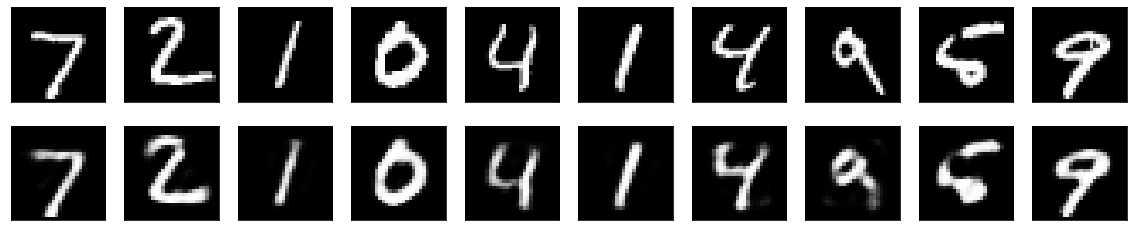

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
